# Introduction

**What you will learn today**: This lab serves as an introduction to PyTorch. We will learn the different steps required in training a deep learning model with modern libraries, such as PyTorch.

So, which are these steps?

* Preliminaries:
    * load the train and test datasets, `train_dataset` and `test_dataset` (MNIST in our case)
    * turn the datasets into a "dataloaders": `train_dataloader` and `test_dataloader`
    * define your `model` architecture
    * define your `optimizer`, e.g. SGD


* Training: Now we have all the building blocks and we need to make our model "learn". In most cases, the training follows a specific "recipe". Specifically, we feed the `model` the whole `train_dataset` using batches that come from the `train_dataloader`. We repeat this a certain number of times, called `epochs`. Each epoch consists of `batches`. So what do we do for each batch?
    * zero out the optimizer. In essence we prepare the optimizer for the incoming data
    * compute the output of the model $f(\cdot)$ for our current data: $x\mapsto f(x)$
    * compute the loss: $\mathcal{L}(f(x), y)$ where $y$ denotes the ground truth
    * perform the `backpropagation` algorithm which involves computing the gradients and performing the update rule



# Getting the preliminaries out of the way

In [2]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

We now load the datasets. We are going to work with MNIST and our goal is classify digits. This is a popular dataset and PyTorch offers it out-of-the-box, making our life easy! We simply need to call the corresponding method.

In [7]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.1307,), (0.3081,))
])

# load the train dataset
# Hint: look at 
# 1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# 2. https://pytorch.org/vision/stable/datasets.html
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

In [8]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


However, we cannot use the whole dataset; it is too large for computers to handle. Instead, we perform *stochastic* gradient descent, i.e. we feed the model part of the data called batches. In order to do so, we use Pytorch DataLoaders. 

In [9]:
# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


Now, let's visualize some samples.

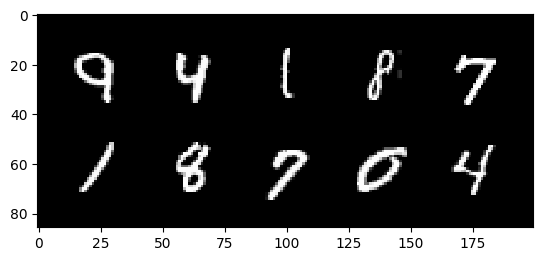

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

Now, we are ready to define our model. We will start with a simple model, a MultiLayer Perceptron (MLP) with 2 layers.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        # define the different modules of the network
        super().__init__()
        # How many features should our model have?
        self.fc1 = nn.Linear(784, 50)

        # How many outputs should our model have?
        self.fc2 = nn.Linear(50, 10)
        # we also define the non-linearity 
        self.relu = nn.ReLU()



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # You should (a) transform the a size that is readable
        # by the MLP and (b) pass the the input x successively 
        # through the layers.
        # ***************************************************
        # transform the image to a vector
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # pass the vectored image through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [12]:
# initialize the model
model = Net()

# move model to device
model = model.to(DEVICE)

# define the optimizer
# Hint: https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

We now define:
* the `fit` function that performs the training part
* the `predict` function that takes as input the test dataloader and prints the performance metrics (e.g. accuracy)

In [13]:
def train_epoch(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()


        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)


def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

    return losses

In [14]:
def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset)

    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')


We perform a "sanity check". Our model is at the moment initialized randomly and we have 10 classes (each class has approximately the same number of samples). This means that we should get random performance -> ~10% accuracy.

In [15]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0011, Accuracy: 1501/10000 (15%)


In [16]:
# train for 10 epochs
losses = fit(
    model=model, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

Epoch 0: Loss=0.002201570745309194
Epoch 1: Loss=0.0020760977466901145
Epoch 2: Loss=0.0019248386065165203
Epoch 3: Loss=0.0017507353941599527
Epoch 4: Loss=0.001567024697860082
Epoch 5: Loss=0.0013905564705530803
Epoch 6: Loss=0.0012333505094051362
Epoch 7: Loss=0.0011001921693483989
Epoch 8: Loss=0.000991692645351092
Epoch 9: Loss=0.0009042636344830195


Let's visualize the loss progression.

Text(0.5, 1.0, 'Loss progression across epochs')

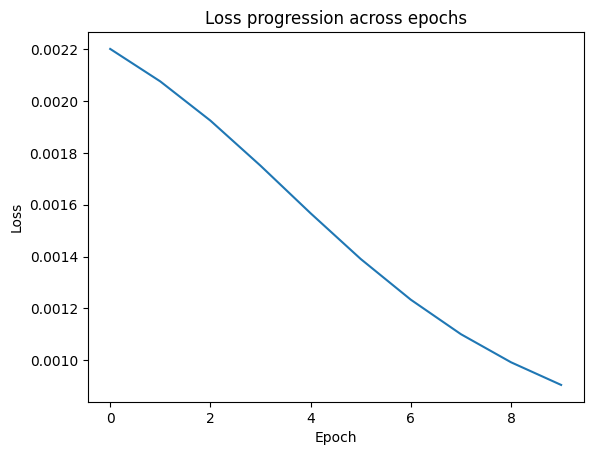

In [17]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")

In [18]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0004, Accuracy: 8209/10000 (82%)


The results are not very good. There are some major problems. We see from the plot above that the loss keeps dropping and does not "plateau". This indicates that we can run the optimization a few more epochs and improve the performance. Another point is that our learning rate is too slow or the selection of vanilla SGD as our optimizer is not optimal. In the next section we will see that simply changing the optimizer (from SGD to Adam) yields very different results!

## CNN

Notice that the MLP does not take into account the nature of images: close pixels convey local information that is important. Using an MLP, we do not have the notion of the "pixel neighbourhood". We, therefore, neglect important information with an MLP. There are however models better suited for vision problems, such as Convolutional Neural Networks or CNNs.

With the code structure we have created, we can simply define a CNN and test its performance quickly.

In [19]:
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()
        # define a CNN with 2 convolutional layers, followed by ReLU and Maxpool each, 
        # and a fully connected layer at the end.
        # Hint: use nn.Sequential()
        # SOLUTION BELOW
        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1, 
                padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
         
              
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)   
        
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)       
        x = self.out(x)
        return x   
        

In [21]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer. Use Adam
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train the CNN
losses = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

Epoch 0: Loss=0.0003325500052422285
Epoch 1: Loss=5.7445143349468705e-05
Epoch 2: Loss=3.858816521242261e-05
Epoch 3: Loss=2.9114783244828383e-05
Epoch 4: Loss=2.68126282064865e-05
Epoch 5: Loss=2.244391745577256e-05
Epoch 6: Loss=1.941856711637229e-05
Epoch 7: Loss=1.5437937574461104e-05
Epoch 8: Loss=1.297989560601612e-05
Epoch 9: Loss=1.16394219493183e-05


In [22]:
# How does the CNN perform compared to the MLP?
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0000, Accuracy: 9886/10000 (99%)


# Exercise: play with CIFAR10

MNIST is a fairly simple dataset. What happens in more challenging datasets?